## Constructing the datasets

We will use vanilla `PyTorch`. We will convert audio to spectrograms and codenames to idices to be used as labels.

In [1]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal

import torch

In [2]:
anno = pd.read_csv('data/annotations.csv')
srs = []
for _, row in anno.iterrows():
    recording, sr = librosa.load(f'data/audio/{row.SndFile}.wav', sr=None)
    srs.append(sr)

In [3]:
set(srs)

{2000, 3012, 22099, 43956, 48000}

The files have been recorded with sample rates varying from 2kHz to 48kHz. Let's downsample all the files to 2kHz.

In [4]:
anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, _ = librosa.load(f'data/audio/{row.SndFile}.wav', sr=2000)
    audio.append(recording[:5000]) # let's take just the first 2.5 seconds of audio
    
anno['audio'] = audio

We now have the audio stored in our pandas dataframe as a column.

In [5]:
anno.head()

,Year,Tape,ElapsedTime,Type,ContextType,QR1,AgeCaller,AgeClassCaller,SexCaller,Callers,QR2,Meters,Directed to,FieldNotes,SndFile,audio
0,1999.0,3.0,1552.0,rumble,lets go,A,54.0,5,Female,Echo,A,15.0,NaN,note that she give sharp ear flap first - this...,B0301552,"[0.0, 0.0, -9.1552734e-05, -0.00079345703, -0...."
1,1999.0,9.0,2708.0,rumble,female chorus,A,54.0,5,Female,Echo,A,10.0,NaN,as tested by Masaku; and another rumble here ...,B0902708,"[0.0, 0.0, 9.1552734e-05, 0.00079345703, 0.003..."
2,1999.0,20.0,2134.0,rumble,cadenced,A,54.0,5,Female,Echo,A,20.0,NaN,NaN,B2002134,"[-0.001953125, 0.0009765625, 0.0014648438, 0.0..."
3,1999.0,20.0,2222.0,rumble,cadenced,A,54.0,5,Female,Echo,A,20.0,NaN,Echo is in the lead facing OTO,B2002222,"[0.000579834, 0.0010681152, -0.00039672852, 0...."
4,1999.0,20.0,2331.0,rumble,cadenced,A,54.0,5,Female,Echo,A,40.0,NaN,NaN,B2002331,"[0.0132751465, 0.012298584, 0.0093688965, 0.01..."


Let's save the modified annotation file that now includes audio so that we can easily access it from other notebooks.

In [6]:
anno.to_pickle('data/anno_with_audio.pkl')

Here is what we need to do for each of the examples:
* convert the audio to a spectrogram
* assign label expressed as an integer

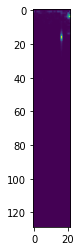

In [7]:
spec = scipy.signal.spectrogram(anno.loc[0, 'audio'])[2]
plt.imshow(spec);

Let us now develop a way of representing labels as integers.

In [8]:
callers = anno['Callers'].unique().tolist()

caller2idx = {caller: idx for idx, caller in enumerate(callers)}

Now that we have the components in place, let's work on our datasets.

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.examples = df
        
    def __getitem__(self, index):
        example = self.examples.iloc[index]
        x = scipy.signal.spectrogram(anno.loc[0, 'audio'])[2]
        y = caller2idx[example['Callers']]
        return x, y

    def __len__(self):
        return self.examples.shape[0]

In [10]:
shuffled = anno.sample(frac=1)

In [11]:
train_ds = Dataset(shuffled.iloc[:250])
valid_ds = Dataset(shuffled.iloc[250:])

Let's now construct the dataloaders to ensure everything works as expected.

In [12]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count()-1
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count()-1
)

In [13]:
for batch in train_dl: pass
for batch in valid_dl: pass

In [14]:
batch[0].shape, batch[1].shape

(torch.Size([32, 129, 22]), torch.Size([32]))